# Policy Improvement

Previously, we learned how to evaluate a policy based on how good it is by computing its expected return (cumulative reward) from each state. This is information is captured by the value function. However, this information doesn’t directly make the agent better at any task. Once the value of a policy is known, we can improve the policy by making it greedier. This means adjusting the policy so that in each state, the agent chooses the action that leads to the highest expected value based on the current value function:

$\displaystyle \pi_{k+1}(s) = \underset{a}{\arg \max}\> q_{\pi_k}(s,a)$

This is similar to what we did in the policy-iteration algorithm in Dynamic Programming: we evaluate, we improve, then evaluate the improved policy, then improve on this improved policy, and so on:

$\pi_0 \overset{evaluate}{\longrightarrow }  q_{\pi_0} \overset{improve}{\longrightarrow } \pi_1 \overset{evaluate}{\longrightarrow }  q_{\pi_1} \overset{improve}{\longrightarrow } \pi_2 \overset{evaluate}{\longrightarrow } ... \overset{improve}{\longrightarrow } \pi_* \overset{evaluate}{\longrightarrow }  q_{\pi_*}$

Howerver, in this case **we are not using a model of the environment** to compute the value function, but we estimate the value function based on samples. This ability allows agents to **learn optimal behavior by trial-and-error learning**, starting from arbitrary policies and ending in optimal ones. This pattern is called **generalized policy iteration (GPI)**, and it can help us create an architecture that virtually any reinforcement learning algorithm fits under, including state-of-the-art deep reinforcement learning agents.

## Slippery Walk environment

We use an environment called **Slippery Walk**. This environment is a walk, a single-row grid-world environment, with seven non-terminal states. The particular thing of this environment is that it’s slippery, like the Fronzen Lake: **action effects are stochastic**. If the agent chooses to go left, there is a chance it does, but there is also a chance that it goes right, or that it stays in place.

![](./images/slippery-walk-environment.png)

This environment is noisy, but the actions the agent selects make a difference in its performance.

In [1]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset();

    def reset(self):
        self.observation_space = 9;
        self.action_space = 2;
        self.state = np.random.choice([1,2,3,4,5,6,7]);
        self.terminated = False;
        return self.state;

    def step(self, action):
        if self.terminated: raise ValueError('Episode has terminated');
        if action not in [0, 1]: raise ValueError('Invalid action');
        
        if(action==0): direction = -1;
        if(action==1): direction = 1;
        
        direction_list = [direction, -direction, 0];
        true_direction = random.choices(direction_list, weights=(50, 16, 33), k=1);
        self.state += true_direction[0];
        
        reward = 0
        if self.state < 1: 
            self.terminated = True;
        if self.state > 7: 
            self.terminated = True; 
            reward = 1;
        
        return self.state, reward, self.terminated, 0, 0;

In [2]:
slippery_walk = SlipperyWalk()

The optimal state value function can be calculated using the MDP and applying the Dynamic Programming:

In [3]:
optimal_v = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.];

## Improving policies after each episode: Monte Carlo control

The **policy improvement theorem** (as already considered in Dynamic Programming) assures that each new policy is better than (or just as good as) the previous one, so the overall process converges to the optimal policy and optimal value function:

$\displaystyle q_{\pi_k}(s, \pi_{k+1}(s)) = q_{\pi_k}(s, \underset{a}{\arg \max}\> q_{\pi_k}(s,a)) 
 = \underset{a}{\max \>} q_{\pi_k}(s,a)) \geq q_{\pi_k}(s, \pi_k(s)) \geq v_{\pi_k}(s)$

In order to implement this idea, we need to **estimates the action-value function, instead of the state-value function**, in order to know what the best action is to take from a state:

$\displaystyle Q(S_t, A_t) = Q(S_t, A_t) + \alpha [G_{t:T} - Q(S_t, A_t)]$

Then, we need to **explore**, becouse we’re no longer using the MDP for the policy-evaluation. When we estimate from samples, we get values for all of the state-action pairs we visited, but what if part of the best states weren’t visited? Let’s start using **first-visit Monte Carlo** for the policy-evaluation phase and a **decaying epsilon-greedy action-selection strategy** for the policy-improvement phase:

In [4]:
def select_action(state, q, epsilon=0.1):

    # if the random number is greater than epsilon, 
    if np.random.uniform() > epsilon:
        # pick the action with the highest Q value
        action = np.argmax(q[state]);
    else:
        # otherwise, pick a random action
        action = np.random.randint(len(q[0]));

    return action;

In order to decay alpha and epsilon, we use the same decay schedule function used in policy evaluation

In [5]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):

    # calculate the number of the remaining steps after the decay
    rem_steps = max_steps - decay_steps;

    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10);

    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min());

    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value;

    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge');

    return values;

We create also a function to calculate all the discount values for the full process:

In [6]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

The generation of a trajectory is slightly different, now we need to select an action following a strategy:

In [7]:
def generate_trajectory(select_action, q, env, epsilon, max_steps=200):

    # list of experiences (trajectory)
    trajectory = [];

    done = False;
    steps = 0;

    # reset the environment to interact in a new episode
    state = env.reset();

    # looping through until the done flag is set to true
    while not done:
        steps += 1; 

        # there is the difference: use the 'select_action' 
        # function to pick an action
        action = select_action(state, q, epsilon);
            
        # step the environment using that action
        next_state, reward, terminated, truncated, info = env.step(action);
        if(terminated or truncated):
            done = True;

        # append the experience to the trajectory
        experience = (state, action, reward, next_state, done);
        trajectory.append(experience);
        
         # if we hit a terminal state break and return
        if done:
            break;

        # truncate long trajectories 
        if steps >= max_steps:
            break;   
       
        # update the state
        state = next_state;
    
    # return the trajectory
    return np.array(trajectory, object);

Then we can write the Monte Carlo control algorithm, which is similar to one for prediction. The two main differences is that we now estimate the action-value function, and we need to explore (we use an decaying epsilon to control random exploration):

In [8]:
def mc_control(env, gamma=0.99, 
               init_alpha=0.5, min_alpha=0.01, 
               init_epsilon=1.0, min_epsilon=0.1, 
               decay_episodes=1000, n_episodes=3000, 
               max_steps=200):
    
    # calculate all discounts at once. 
    discounts = decay_discounts(gamma, max_steps);
    
    # calculate all alphas at once
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);
        
    # calculate all epsilons in advance
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space, env.action_space), dtype=float);
    
    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);
    
    # the episode loop    
    for e in range(n_episodes):
        
        # generate a trajectory using the exploratory policy
        trajectory = generate_trajectory(select_action, q, env, epsilons[e], max_steps);
        
        # initialize a visits check vector
        visited = np.zeros((env.observation_space, env.action_space), dtype=bool);
        
        # loop through all experiences in the trajectory
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            
            # check if the state-action has already been visited (first-visit MC)
            if visited[state][action]: 
                continue;
            visited[state][action] = True;
            
            # calculate the number of steps from t to T
            n_steps = len(trajectory[t:]);

            # calculate the return
            g = np.sum(discounts[:n_steps] * trajectory[t:, 2]);

            # estimate the value functions
            q[state][action] = q[state][action] + alphas[e] * (g - q[state][action]);

        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);

        # save values for post analysis
        v_track[e] = v;
    
    return q, v, pi, v_track;

Let’s test the algorithm in the Slippery Walk Seven environment: 

In [9]:
q_mc, v_mc, pi_mc, v_track_mc = mc_control(slippery_walk);

We can show the estimates over episodes:

In [10]:
print(v_mc)

[0.         0.51766928 0.75137864 0.85185793 0.8995707  0.92551138
 0.95674347 0.98337021 0.        ]


Of course, the optimal policy learned is obvious in this case, but the algorithm is able to learn it:

In [54]:
def print_policy(pi, env):
    for state in range(env.observation_space):
        action = pi(state)
        action_icon = ' '
        if action == 0: action_icon = 'L'
        if action == 1: action_icon = 'R'
        print('state:', state, '->', 'action:', action_icon)

In [55]:
print_policy(pi_mc, slippery_walk)

state: 0 -> action: L
state: 1 -> action: R
state: 2 -> action: R
state: 3 -> action: R
state: 4 -> action: R
state: 5 -> action: R
state: 6 -> action: R
state: 7 -> action: R
state: 8 -> action: L


We can show the difference between the estimates and the real values:

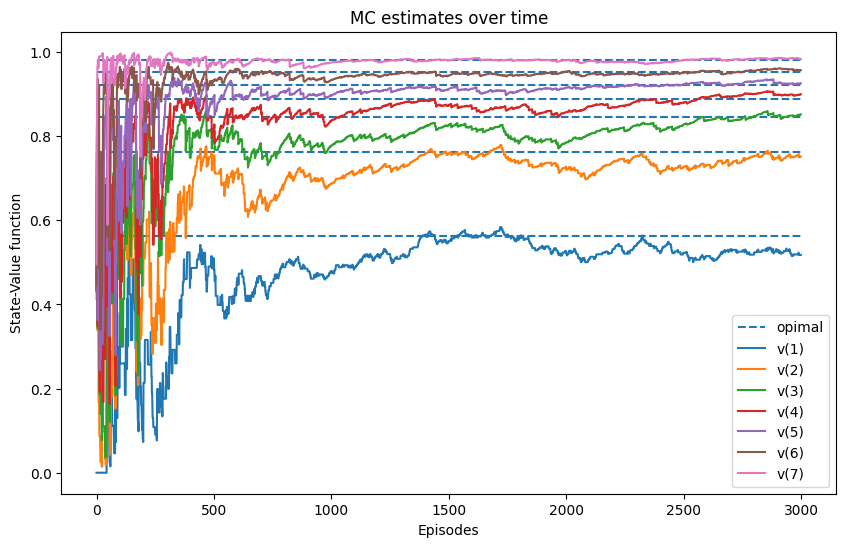

In [11]:
import matplotlib.pyplot as plt

legends = ['opimal', 'v(1)','v(2)','v(3)','v(4)','v(5)', 'v(6)', 'v(7)'];
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_mc[:,1:8]);
plt.title('MC estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);
plt.show();

Notice how **the estimates of MC have high variance**. We can use a brute-force approach to get the average return of the policy and its success probability.

In [12]:
def evaluate(env, pi, n_episodes=1000, max_steps=200):
    success = 0;
    results = [];
    for _ in range(n_episodes):
        done = False;
        steps = 0;
        state = env.reset();
        results.append(0.0);
        while not done and steps < max_steps:
            state, reward, terminated, truncated, info = env.step(pi(state));
            if(terminated or truncated):
                done = True;
            results[-1] += reward;
            steps += 1;
        if(done and reward==1):
            success += 1;
    return (success/n_episodes)*100, np.mean(results);

In [13]:
probability_success_mc, mean_return_mc = evaluate(slippery_walk, pi_mc);

print("Reaches goal ", probability_success_mc, "%");
print("Obtains an average undiscounted return of ", mean_return_mc);

Reaches goal  93.30000000000001 %
Obtains an average undiscounted return of  0.933


## Improving policies after each step: SARSA

Monte Carlo method is an **offline** method in an episode-to-episode sense: we must wait until a terminal state before we can make any improvements to the value function estimate. So, it is straightforward to apply **temporal-difference prediction** for the policy-evaluation phase in order to remove this limitation. The algorithm is called **SARSA agent** ([Rummery & Niranjan, "Online Q-Learning using Connectionist Systems" (1994)](./papers/1994%20-%20Online%20Q-Learning%20using%20Connectionist%20Systems.pdf):

$\displaystyle G_{t:t+1} = R_{t+1} + \gamma Q(S_{t+1}, A_{t+1})$

We can substitute in the formula for the evaluation of the action-value function:

$\displaystyle Q(S_t, A_t) = Q(S_t, A_t) + \alpha_t [G_{t:t+1} - Q(S_t, A_t)]$

where $G_{t:t+1}$ is the **SARSA target** and $G_{t:t+1} - Q(S_t, A_t)$ is the **SARSA error**.

We can implement it in Python:

In [14]:
def sarsa(env, gamma=0.99, 
          init_alpha=0.5, min_alpha=0.01, 
          init_epsilon=1.0, min_epsilon=0.1, 
          decay_episodes=1000, n_episodes=3000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space, env.action_space), dtype=float);
    
    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);

    # the episode loop    
    for e in range(n_episodes):
        
        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;
        
        # select the action (perhaps exploratory) for the initial state
        action = select_action(state, q, epsilons[e]);
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # obtain the action for the next step
            next_action = select_action(next_state, q, epsilons[e]);
            
            # calculate the target using that next state-action pair
            sarsa_target = reward + gamma * q[next_state][next_action]
            
            # calculate the error                                   
            sarsa_error = sarsa_target - q[state][action];
            
            # update the action-value function
            q[state][action] = q[state][action] + alphas[e] * sarsa_error;
                        
            # update state and action for the next step
            state, action = next_state, next_action;
            
        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);

        # save values for post analysis   
        v_track[e] = v;
    
    return q, v, pi, v_track;

Now we can run SARSA against the  Slippery Walk environment:

In [15]:
q_sarsa, v_sarsa, pi_sarsa, v_track_sarsa = sarsa(slippery_walk);

In [16]:
print(v_sarsa);

[0.         0.50793413 0.72153735 0.81910682 0.87309208 0.91716808
 0.94639632 0.97422209 0.        ]


We can show the estimates over episodes and the difference between the estimates and the real values:

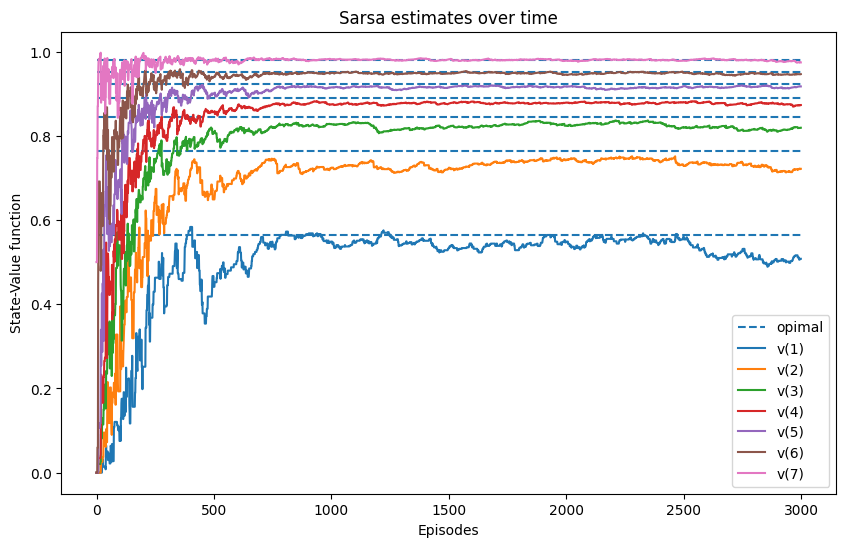

In [17]:
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_sarsa[:,1:8]);
plt.title('Sarsa estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);
plt.show();

We can see how SARSA has less variance than MC, but it slower to converge, particularly for low-value states. Again, we can use the brute-force approach to get the average return of the policy and its success probability:

In [18]:
probability_success_sarsa, mean_return_sarsa = evaluate(slippery_walk, pi_sarsa);

print("Reaches goal ", probability_success_sarsa, "%");
print("Obtains an average undiscounted return of ", mean_return_sarsa);

Reaches goal  93.30000000000001 %
Obtains an average undiscounted return of  0.933


Monte Carlo and SARSA must meet some requirements to guarantee convergence to the optimal policy: (a) **all state-action pairs must be explored infinitely often** and (b) **the policy must converge on a greedy policy**. In practice, this means that an the epsilon-greedy exploration strategy must slowly decay epsilon towards zero. If it goes down too quickly, the first condition may not be met; if it decays too slowly, well, it takes longer to converge.

## Decoupling behavior from learning: Q-Learning

The SARSA algorithm is a sort of "learning on the job", the agent learns the value of the policy it is currently following, which means it **evaluates and improves the same policy that it is using to make decisions**. The agent explores and exploits the environment according to the same policy it is updating. This type of learning is called **on-policy learning**. It is excellent, we learn from our own mistakes. But we learn from our own current mistakes only. What if we want to learn from our own previous mistakes? What if we want to learn from the mistakes of others? The **Off-policy learning** approach is sort of "learning from others": the agent **learns the value of an optimal policy, but it follows a different behavior policy to explore** the environment. In other words, it separates the policy it uses to explore (**behavior policy**) from the policy it is trying to optimize (**target policy**). The most used off-policy algorithm is called **Q-Learning** ([Watkins, "Learning from Delayed Rewards" (1989)](./papers/1989%20-%20Learning%20from%20Delayed%20Rewards.pdf). The difference between SARSA and Q-learning is the action used to calculate the target. SARSA uses the action taken in the next state, Q-learning uses the action with the maximum estimated value in the next state, despite the action taken:

$\displaystyle G_{t:t+1} = R_{t+1} + \gamma \underset{a}{\text{ max }} Q(S_{t+1}, a)$

We can substitute in the formula for the evaluation of the action-value function:

$\displaystyle Q(S_t, A_t) = Q(S_t, A_t) + \alpha_t [G_{t:t+1} - Q(S_t, A_t)]$

where $G_{t:t+1}$ is the **Q-learning target** and $G_{t:t+1} - Q(S_t, A_t)$ is the **Q-learning error**.

Q-Learning algorithm will evaluate all possible state-actions pairs and choose that pair which will generate maximum expected rewards (which is the value of the state). Off-policy methods can converge faster because they are not restricted by the exploration-exploitation balance of the behavior policy. We can implement it in Python:

In [19]:
def q_learning(env, gamma=0.99, 
               init_alpha=0.5, min_alpha=0.01, 
               init_epsilon=1.0, min_epsilon=0.1, 
               decay_episodes=1000, n_episodes=3000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space, env.action_space), dtype=float);
    
    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);
    
    # the episode loop    
    for e in range(n_episodes):

        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;

        # repeat until we hit a terminal state
        while not done:

            # select the action
            action = select_action(state, q, epsilons[e]);

            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # calculate the target: here is Q-learning!
            q_learning_target = reward + gamma * q[next_state].max();
            
            # calculate the error 
            q_learning_error = q_learning_target - q[state][action];

            # update the action-value function
            q[state][action] = q[state][action] + alphas[e] * q_learning_error;

            # update state for the next step
            state = next_state;

        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);
        
        # save values for post analysis   
        v_track[e] = v;

    return q, v, pi, v_track;

Now we can run Q-Learning against the  Slippery Walk environment:

In [20]:
q_ql, v_ql, pi_ql, v_track_ql = q_learning(slippery_walk);

In [21]:
print(v_ql)

[0.         0.57041535 0.7842639  0.85743426 0.89535881 0.92255083
 0.949536   0.98243429 0.        ]


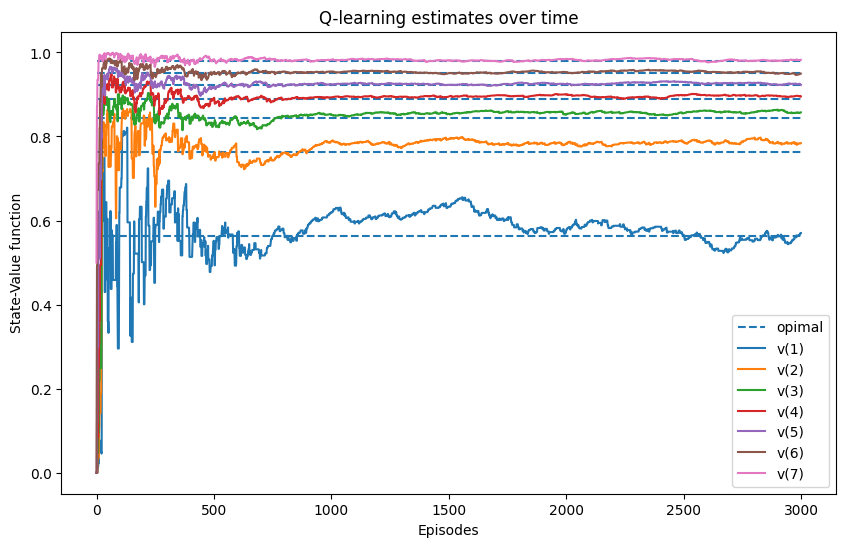

In [22]:
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_ql[:,1:8]);
plt.title('Q-learning estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);
plt.show();

See how much **faster** the estimates track the true values. But, also, notice how the estimates are often higher and **jump around** somewhat aggressively.

In [23]:
probability_success_ql, mean_return_ql = evaluate(slippery_walk, pi_ql);

print("Reaches goal ", probability_success_ql, "%");
print("Obtains an average undiscounted return of ", mean_return_ql);

Reaches goal  92.60000000000001 %
Obtains an average undiscounted return of  0.926


Notice that for off-policy algorithms the only requirement that holds of the two for convergence is the first one (all state-action pairs must be explored infinitely often). The second one (the policy must converge on a greedy policy) is no longer a requirement, because the learned policy is different than the one used to sampling actions.

## Solving the maximization bias: Double Q-Learning

Q-learning often **overestimates the value function**. On every step, we take the **maximum over the estimates** of the action-value function of the next state, but what we need is an **estimate of the maximum** of the action-value function of the next state. We are using the **maximum over estimates as an estimate of the maximum**. Consider the Q-learning update rule:

$\displaystyle G_{t:t+1} = R_{t+1} + \gamma \underset{a}{\text{ max }} Q(S_{t+1}, a)$

$\displaystyle Q(S_t, A_t) = Q(S_t, A_t) + \alpha_t [G_{t:t+1} - Q(S_t, A_t)]$

Here, the maximum over the estimates is used to select the action with the maximum estimated future reward. However, if the estimates of are noisy or imprecise (which is often the case early in training), the **maximization tends to select actions with overestimated values**. This leads to a systematic bias towards overestimating the value of the chosen actions. This is a problem known as **maximization bias**. Imagine an action-value function whose actual values are all zeros, but the estimates have errors (0.11, 0.65, –0.44, –0.26, and so on). We know the actual maximum is zero, but the maximum over the estimates is 0.65. One way of dealing with this is a technique called **double Q-learning** [Hasselt, Hado. "Double Q-learning." Advances in neural information processing systems NIPS (2010)](./papers/2010%20-%20Double%20Q-learning.pdf). In this approach, two separate action-value estimates are maintained, and the update rule is modified to reduce bias. One action-value function is used to select the action with the maximum value. The other action-value function is used to evaluate the value of that action, thus **breaking the dependence between action selection and value estimation**. This approach helps to reduce the overestimation problem by decoupling the action selection from the max operator, leading to more stable and accurate learning. The issue, though, is now we are splitting the experience between two separate functions and this somewhat **slows down training**. Other Methods, like **Weighted Q-learning** and **softmax selection** can also mitigate the bias, though they are less common compared to Double Q-learning. We can implement the idea in Python:

In [ ]:
def double_q_learning(env, gamma=0.99, 
                      init_alpha=0.5, min_alpha=0.01, 
                      init_epsilon=1.0, min_epsilon=0.1, 
                      decay_episodes=1000, n_episodes=3000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the two action-value functions
    q1 = np.zeros((env.observation_space, env.action_space), dtype=float);
    q2 = np.zeros((env.observation_space, env.action_space), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);
    
    # the episode loop    
    for e in range(n_episodes):

        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;

        # repeat until we hit a terminal state
        while not done:
            
            # we use the mean of our two action-value functions to select action 
            action = select_action(state, (q1 + q2)/2., epsilons[e]);

            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # flip a coin to determine an update to q1 or q2
            if np.random.randint(2):

                # use the action q1 thinks is best...
                argmax_q1 = np.argmax(q1[next_state]);
                
                # ...but get the value from q2 to calculate the target
                dq_learning_target = reward + gamma * q2[next_state][argmax_q1];

                # calculate the error 
                dq_learning_error = dq_learning_target - q1[state][action];
                
                # update q1
                q1[state][action] = q1[state][action] + alphas[e] * dq_learning_error;

            else:
                
                # use the action q2 thinks is best...
                argmax_q2 = np.argmax(q2[next_state]);
                
                # ...but get the value from q1 to calculate the target
                dq_learning_target = reward + gamma * q1[next_state][argmax_q2];
                dq_learning_error = dq_learning_target - q2[state][action];
                
                # update q2
                q2[state][action] = q2[state][action] + alphas[e] * dq_learning_error;
            
            # update state
            state = next_state;
        
        # extract the value functions
        q = (q1 + q2)/2.;
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);
        
        # save values for post analysis
        v_track[e] = v
    
    return q, v, pi, v_track;

Now we can run Double Q-Learning against the  Slippery Walk environment:

In [25]:
q_dql, v_dql, pi_dql, v_track_dql = double_q_learning(slippery_walk);

In [26]:
print(v_dql)

[0.         0.58634552 0.7786524  0.85104747 0.89197395 0.92670831
 0.95368596 0.98076035 0.        ]


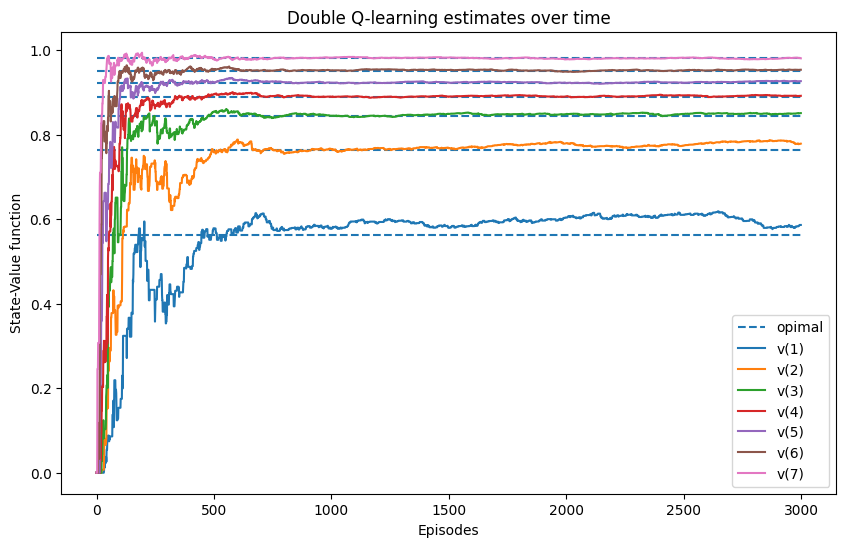

In [27]:
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_dql[:,1:8]);
plt.title('Double Q-learning estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);
plt.show();

It is **slightly slower** than Q-learning to get the estimates to track the optimal values, but it does so in a **much more stable manner**. There’s still a bit of over-estimation, but it’s controlled.

## Using multi-step estimates: SARSA(lambda)

A straightforward improvement to the original SARSA agent is **to use the lambda-return  instead of using a one-step bootstrapping target**. For adapting the eligibility trace to the estimation of action-value function, instead of using a vector for tracking visited states, we use an **eligibility matrix** for tracking visited state-action pairs. When the agent tries a state-action pair, the trace for this pair is incremented by one. Now, imagine there is a loop in the environment, and the agent tries the same state-action pair several times. Should we make this state-action pair **"more" responsible** for rewards obtained in the future, or should we make it **just responsible**? The first type of eligibility trace is called **accumulating trace** (and allows trace values higher than one), the other one is the **replacing trace** (it clips eligibility traces to a maximum value of one). The following figure shows the two strategy applied to the Slippery Walk environment:

![](./images/eligibility-matrix.png)

Accumulating traces can "exaggerate" when confronted with frequency, while replacing traces moderate the blame assigned to frequent events. This moderation can help the more recent, but rare events surface and be taken into account. We can implement this variation of SARSA in Python:

In [ ]:
def sarsa_lambda(env, gamma=0.99, 
                 init_alpha=0.5, min_alpha=0.01, 
                 init_epsilon=1.0, min_epsilon=0.1, 
                 lambda_=0.5, replacing_traces=True,
                 decay_episodes=1000, n_episodes=3000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space, env.action_space), dtype=float);

    # eligibility traces
    E = np.zeros((env.observation_space, env.action_space), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);

    # the episode loop
    for e in range(n_episodes):
      
        # every new episode, set the eligibility of every state to zero
        E.fill(0);

        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;

        # select the action (perhaps exploratory) for the initial state
        action = select_action(state, q, epsilons[e]);
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # obtain the action for the next step
            next_action = select_action(next_state, q, epsilons[e]);

            # calculate the target using that next state-action pair
            sarsa_lambda_target = reward + gamma * q[next_state][next_action];
            
            # calculate the error  
            sarsa_lambda_error = sarsa_lambda_target - q[state][action];
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0);
            E[state][action] = E[state][action] + 1;
            if replacing_traces: 
                E.clip(0, 1, out=E);
            
            # apply the error to all eligible state-action pairs at once
            # even though we're using the entire q-table, E will be mostly 0, 
            # and greater than zero for eligible pairs
            q = q + alphas[e] * sarsa_lambda_error * E;
            
            # decay the eligibility matrix
            E = lambda_ * E;
            
            # update state and action for the next step
            state, action = next_state, next_action;
        
        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);

        # save values for post analysis   
        v_track[e] = v;
    
    return q, v, pi, v_track;

We can apply the algorithm to the same SWS environment:

In [29]:
q_sarsa_lambda, v_sarsa_lambda, pi_sarsa_lambda, v_track_sarsa_lambda = sarsa_lambda(slippery_walk);

In [30]:
print(v_sarsa_lambda);

[0.         0.49629043 0.713757   0.81630604 0.88155212 0.9197797
 0.94863288 0.9778924  0.        ]


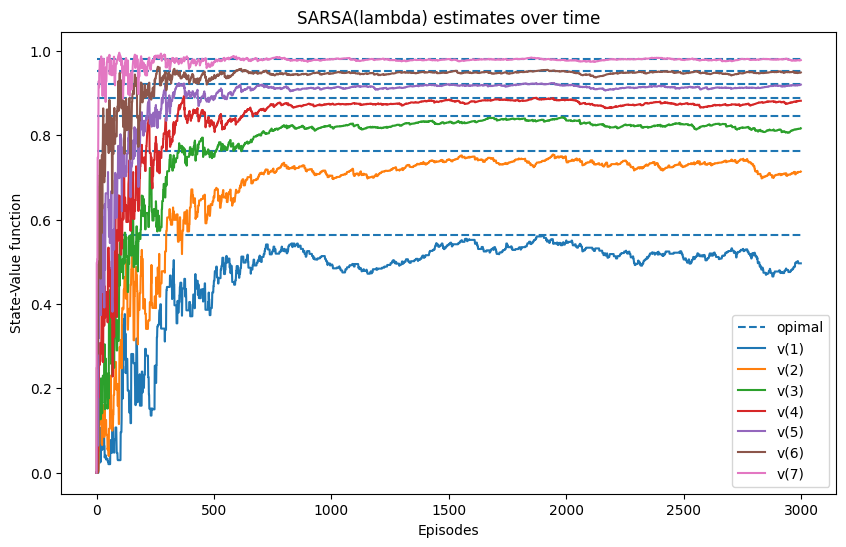

In [31]:
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_sarsa_lambda[:,1:8]);
plt.title('SARSA(lambda) estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);
plt.show();

By updating past state-action pairs, Sarsa(almbda) learns faster in environments where rewards are delayed. It is better at distributing the reward credit over multiple past actions, making it effective in tasks with longer time dependencies. However it requires maintaining eligibility traces and tuning the lambda parameter, making it more computationally demanding than regular Sarsa. Moreover, the choice of lambda can significantly affect performance, and improper tuning might degrade learning performance.

## Using multi-step estimates and decoupling behaviour from learning: Q(lambda)

We can extend also the Q-learning in order to use the lambda-return for evaluation. We need to replace the target (that uses the max over the action in the next state) with a lambda-return. Moreover, since Q-learning is an off-policy method, we must use the eligibility trace with care. We’re learning about the greedy policy, but following an exploratory policy. So, if an action we’ll take on the next state is a greedy action (so if the exploratory policy follows the same path of the greedy policy), then we decay the eligibility matrix as usual. Otherwise, we must reset the eligibility matrix to zero because we’ll no longer be learning about the greedy policy. We implement this idea in Python:

In [32]:
def q_lambda(env, gamma=0.99, 
             init_alpha=0.5, min_alpha=0.01, 
             init_epsilon=1.0, min_epsilon=0.1, 
             lambda_=0.5, replacing_traces=True,
             decay_episodes=1000, n_episodes=3000):
    
    # calculate the learning rate schedule for all episodes    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes);

    # calculate epsilon for all episodes   
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes);

    # initialize the current estimate of the action-value function
    q = np.zeros((env.observation_space, env.action_space), dtype=float);
        
    # eligibility traces
    E = np.zeros((env.observation_space, env.action_space), dtype=float);

    # create a list to save copies of v for offline analysis
    v_track = np.zeros((n_episodes, env.observation_space), dtype=float);
    
    # the episode loop 
    for e in range(n_episodes):
        
        # every new episode, set the eligibility of every state to zero
        E.fill(0);
        
        # we start episode by resetting the environment and the done flag
        state, done = env.reset(), False;
        
        # notice: we are preselecting the action as in SARSA, (we didn’t do that in Q-learning) 
        # this is because we need to check whether our next action is greedy for deciding
        # to decay the eligibility trace
        action = select_action(state, q, epsilons[e])
        
        # repeat until we hit a terminal state
        while not done:
            
            # step the environment using that action
            next_state, reward, terminated, truncated, info = env.step(action);
            if(terminated or truncated):
                done = True;
            
            # select the next_action SARSA-style
            next_action = select_action(next_state, q, epsilons[e])
            
            # use it to verify that the action on the next step 
            # will still come from the greedy policy
            next_action_is_greedy = q[next_state][next_action] == q[next_state].max()

            # still calculate the target as in regular Q-learning, using the max
            q_lambda_learning_target = reward + gamma * q[next_state].max();
            
            # and use the target to calculate TD error
            q_lambda_learning_error = q_lambda_learning_target - q[state][action];
            
            # increment the state-action pair trace, 
            # and clip it to 1 if it’s a replacing trace
            if replacing_traces: 
                E[state].fill(0);
            E[state][action] = E[state][action] + 1
            if replacing_traces: 
                E.clip(0, 1, out=E);
            
            # as before, we multiply the entire eligibility trace matrix 
            # by the error and the learning rate corresponding to episode e, 
            q = q + alphas[e] * q_lambda_learning_error * E
            
            # if the action we’ll take on the next state (which we already selected) is a greedy action, 
            # then we decay the eligibility matrix as usual, otherwise, we must reset 
            # the eligibility matrix to zero because we’ll no longer be learning about the greedy policy
            if next_action_is_greedy:
                E =  lambda_ * E;
            else:
                E.fill(0);
            
            # update state and action for the next step
            state, action = next_state, next_action

        # extract the state-value function   
        v = np.max(q, axis=1);

        # and the greedy policy
        def pi(s):
            return np.argmax(q[s]);
        
        # save values for post analysis  
        v_track[e] = v;

    return q, v, pi, v_track;

We can apply the algorithm to the same SWS environment:

In [33]:
q_ql_lambda, v_ql_lambda, pi_ql_lambda, v_track_ql_lambda = q_lambda(slippery_walk);

In [34]:
print(v_ql_lambda)

[0.         0.57036203 0.76187365 0.84324413 0.89254433 0.92592254
 0.9528339  0.98104672 0.        ]


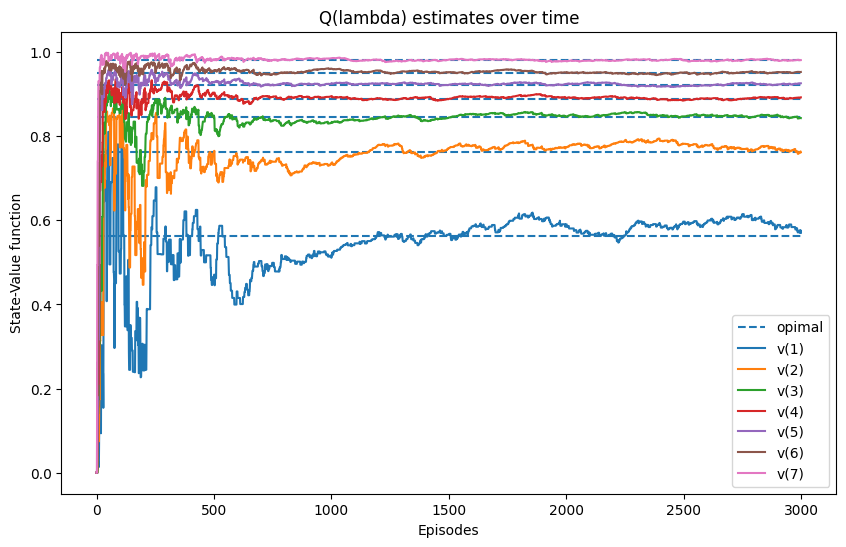

In [35]:
plt.figure(figsize=(10,6));
plt.hlines(optimal_v[1:8], 0, 3000, linestyle='--');
plt.plot(v_track_ql_lambda[:,1:8]);
plt.title('Q(lambda) estimates over time');
plt.ylabel('State-Value function');
plt.xlabel('Episodes');
plt.legend(legends);
plt.show();

Also in this case, by using eligibility traces to update not only the current state-action pair, but also past state-action pairs that contributed to the current reward, Q(lambda) can learn faster by assigning credit to prior states. However, the same observations on complexity and the need for tuning made for Sarsa(lambda) apply to Q(lambda) as well.

## Comparison

In order to compare the different algorithms, we can consider the state-value function estimation error as the mean absolute error across all estimates from their respective optimal. Take a look at how quickly Q-learning drops near zero, but also how double Q-learning gets to the lowest error first: 

In [36]:
def moving_average(a, n=100) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

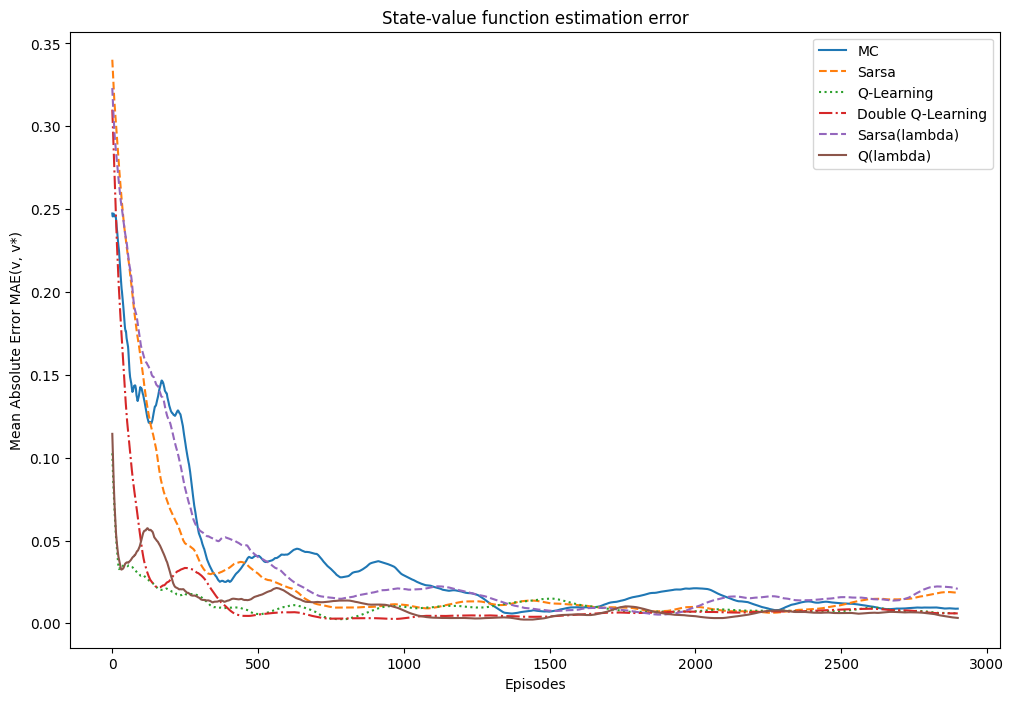

In [37]:
plt.figure(figsize=(12,8))
plt.plot(moving_average(np.mean(np.abs(v_track_mc - optimal_v), axis=1)), '-', label='MC');
plt.plot(moving_average(np.mean(np.abs(v_track_sarsa - optimal_v), axis=1)), '--', label='Sarsa');
plt.plot(moving_average(np.mean(np.abs(v_track_ql - optimal_v), axis=1)), ':', label='Q-Learning');
plt.plot(moving_average(np.mean(np.abs(v_track_dql - optimal_v), axis=1)), '-.', label='Double Q-Learning');
plt.plot(moving_average(np.mean(np.abs(v_track_sarsa_lambda - optimal_v), axis=1)), '--', label='Sarsa(lambda)');
plt.plot(moving_average(np.mean(np.abs(v_track_ql_lambda - optimal_v), axis=1)), '-', label='Q(lambda)');
plt.legend(loc=1, ncol=1);
plt.title('State-value function estimation error');
plt.xlabel('Episodes');
plt.ylabel('Mean Absolute Error MAE(v, v*)');
plt.show();

In the end, Monte Carlo is simple but slow and limited to episodic tasks; Sarsa is more conservative, focusing on actions based on the current policy, and works well when stability is needed; Q-learning aggressively learns the optimal policy but is prone to overestimation. Double Q-learning is a better alternative when stability is a concern, as it mitigates overestimation. Sarsa(lambda) and Q(lambda) provide a middle ground between learning speed and robustness by using eligibility traces, with Q(lmbda) being faster due to its off-policy nature. The choice of algorithm often depends on the specific environment and the need for stability, exploration, and learning speed.